In [30]:
# =======================================================
# 6. AI-Driven Trend Forecasting
# Goal: Predict the next viral trends on TikTok using ML
# =======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV # Added GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.combine import SMOTETomek
from IPython.display import display # Added for displaying DataFrames in Jupyter-like environments



In [31]:
# --- 1. Load Data ---
# Assuming the CSV file is in the correct path relative to the script
try:
    df = pd.read_csv('data/processed/tiktok_processed_with_nlp_features.csv', parse_dates=['create_time'])
except FileNotFoundError:
    print("Error: The data file 'data/processed/tiktok_processed_with_nlp_features.csv' was not found.")
    print("Please ensure the file path is correct.")
    exit()

df['clean_description'] = df['clean_description'].fillna("").astype(str)
df['create_time'] = pd.to_datetime(df['create_time'])
df = df.sort_values('create_time')



In [32]:
# --- 2. Define Features ---
numerical_features = [
    'likes', 'comments', 'shares', 'plays', 'hashtag_count',
    'description_length', 'sentiment_polarity'
]
categorical_features = ['author', 'day_of_week', 'is_weekend', 'time_period'] # Ensure 'author' does not have too many unique values for OHE
text_feature = 'clean_description'

# --- 3. Define Viral Threshold ---
# Using a quantile-based threshold for defining 'viral'
threshold = df['virality_score_normalized'].quantile(0.80)
df['is_viral'] = (df['virality_score_normalized'] >= threshold).astype(int)


In [33]:
# --- 4. Label Future Viral Videos (24h and 7d) ---
def label_viral_next_period(df, period_hours):
    df_sorted = df.sort_values('create_time').copy() # Use .copy() to avoid SettingWithCopyWarning
    # Calculate future virality and time for videos by the same author
    df_sorted['future_virality'] = df_sorted.groupby('author')['virality_score_normalized'].shift(-1)
    df_sorted['future_time'] = df_sorted.groupby('author')['create_time'].shift(-1)
    
    # Calculate time difference in hours
    df_sorted['delta_hours'] = (df_sorted['future_time'] - df_sorted['create_time']).dt.total_seconds() / 3600
    
    # Mask for videos within the specified future period
    mask = (df_sorted['delta_hours'] > 0) & (df_sorted['delta_hours'] <= period_hours)
    
    # Label if the future video (within the period) is viral
    df_sorted['is_viral_next'] = ((df_sorted['future_virality'] >= threshold) & mask).astype(int)
    return df_sorted

df_24h = label_viral_next_period(df, 24)
df_7d = label_viral_next_period(df, 24*7)



In [34]:
# --- 5. Preprocessing Pipeline ---
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
    ('txt', TfidfVectorizer(max_features=100, stop_words='english', ngram_range=(1,2)), text_feature), # Increased max_features, added ngrams, added text_feature
], remainder='drop') # Explicitly drop other columns

# Feature Selector
selector = SelectKBest(score_func=f_classif, k=50) # Increased k, ensure k <= total features after preprocessing

# --- 6. Trend Forecasting Function (with GridSearchCV and Feature Importance) ---
def run_trend_forecasting(df_labeled, target_col, preprocessor, selector):
    feature_cols = numerical_features + categorical_features + [text_feature]
    
    # Drop rows where the target is NaN (e.g., last videos of an author for future labeling)
    df_valid = df_labeled[df_labeled[target_col].notna()].copy()
    if df_valid.empty:
        print(f"No valid data for target {target_col} after filtering NaNs. Skipping.")
        return pd.DataFrame()

    X = df_valid[feature_cols]
    y = df_valid[target_col]

    if len(y.unique()) < 2:
        print(f"Target column {target_col} has less than 2 unique values. Skipping model training.")
        return pd.DataFrame()
    
    # Stratified split to preserve class balance
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Preprocessing
    X_train_proc = preprocessor.fit_transform(X_train)
    X_test_proc = preprocessor.transform(X_test)
    
    # Get feature names after preprocessing (ColumnTransformer)
    try:
        # For scikit-learn >= 1.0, get_feature_names_out is preferred
        feature_names_transformed = preprocessor.get_feature_names_out()
    except AttributeError:
        # Fallback for older scikit-learn versions (manual construction can be complex)
        # This is a simplified fallback; robust construction needs care
        num_names = numerical_features
        cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
        txt_names = preprocessor.named_transformers_['txt'].get_feature_names_out()
        feature_names_transformed = list(num_names) + list(cat_names) + list(txt_names)


    # Handle class imbalance using SMOTETomek
    # Apply SMOTE only if there are enough samples in the minority class for k_neighbors
    minority_class_count = y_train.value_counts().min()
    if minority_class_count > 1 and minority_class_count >= 5 : # SMOTE default k_neighbors is 5
        smote = SMOTETomek(random_state=42, n_jobs=-1)
        X_train_res, y_train_res = smote.fit_resample(X_train_proc, y_train)
    else:
        print(f"Skipping SMOTETomek for {target_col} due to insufficient minority samples ({minority_class_count}). Using original training data.")
        X_train_res, y_train_res = X_train_proc, y_train


    # Feature selection (ensure k is not greater than number of features)
    current_k = min(selector.k, X_train_res.shape[1])
    if selector.k > X_train_res.shape[1]:
        print(f"Warning: k for SelectKBest ({selector.k}) is > num features ({X_train_res.shape[1]}). Using k={current_k}.")
    
    current_selector = SelectKBest(score_func=f_classif, k=current_k)
    current_selector.fit(X_train_res, y_train_res)
    X_train_sel = current_selector.transform(X_train_res)
    X_test_sel = current_selector.transform(X_test_proc) # Transform test set using already fitted selector

    # Get selected feature names
    selected_indices = current_selector.get_support(indices=True)
    selected_feature_names = [feature_names_transformed[i] for i in selected_indices]

    # Hyperparameter tuning with GridSearchCV
    param_grid = {
        'n_estimators': [100, 150],       # Number of trees
        'max_depth': [7, 10, None],       # Max depth of trees
        'min_samples_split': [2, 5],    # Min samples to split a node
        'min_samples_leaf': [1, 3],     # Min samples at a leaf node
        'class_weight': ['balanced', 'balanced_subsample', None] # Address imbalance if SMOTE isn't perfect
    }
    
    # Use a simpler grid if computation time is an issue
    # param_grid = {
    #     'n_estimators': [100], 'max_depth': [7], 'class_weight': ['balanced']
    # }

    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        param_grid,
        cv=3, # 3-fold cross-validation, can be increased to 5
        scoring='roc_auc', # Focus on ROC AUC for imbalanced classes
        n_jobs=-1, # Use all available cores for GridSearchCV
        verbose=1 # Shows progress
    )
    
    grid_search.fit(X_train_sel, y_train_res)
    
    print(f"\nBest parameters found for {target_col}: {grid_search.best_params_}")
    model = grid_search.best_estimator_

    # Predictions and Probabilities
    y_proba = model.predict_proba(X_test_sel)[:, 1]
    
    # Adjust prediction threshold (can be optimized based on Precision-Recall curve)
    prediction_threshold = 0.4 # Adjusted from 0.3, this is a hyperparameter to tune
    y_pred = (y_proba >= prediction_threshold).astype(int)

    # Evaluation
    print(f"\n--- Evaluation for {target_col} (Prediction Threshold: {prediction_threshold}) ---")
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Feature Importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': selected_feature_names,
            'importance': importances
        }).sort_values(by='importance', ascending=False)
        
        print("\nTop 10 Feature Importances:")
        # Use display for better formatting in Jupyter, otherwise print
        try:
            display(feature_importance_df.head(10))
        except NameError:
            print(feature_importance_df.head(10))

    # ROC Curve Plot
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
    plt.plot([0, 1], [0, 1], 'k--') # Diagonal reference line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {target_col}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Output: Top viral predictions as DataFrame
    X_test_original_indices = y_test.index # Get original indices from y_test
    viral_videos_info = df_valid.loc[X_test_original_indices].copy()
    viral_videos_info['predicted_proba'] = y_proba
    viral_videos_info['predicted_label'] = y_pred
    
    # Select relevant columns for the output
    output_columns = ['video_id', 'create_time', 'clean_description', 'author', 'hashtag_list', 'hashtag_count', 'predicted_proba', 'is_viral']
    # Ensure all output columns exist in viral_videos_info
    output_columns = [col for col in output_columns if col in viral_videos_info.columns]

    viral_output = viral_videos_info[viral_videos_info['predicted_label'] == 1][output_columns]
    viral_output = viral_output.sort_values(by='predicted_proba', ascending=False).head(20) # Show top 20
    
    return viral_output

Starting Trend Forecasting for Next 24 Hours...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits

Best parameters found for is_viral_next: {'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

--- Evaluation for is_viral_next (Prediction Threshold: 0.4) ---
ROC-AUC Score: 0.4757
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1438
           1       0.00      0.00      0.00         7

    accuracy                           0.99      1445
   macro avg       0.50      0.50      0.50      1445
weighted avg       0.99      0.99      0.99      1445


Top 10 Feature Importances:

Best parameters found for is_viral_next: {'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

--- Evaluation for is_vi

,feature,importance
2,cat__author_barstoolsports,0.138667
28,cat__day_of_week_2,0.093446
0,num__hashtag_count,0.066835
43,txt__nba,0.063373
47,txt__tiktok,0.049729
32,txt__el,0.038742
1,num__sentiment_polarity,0.035486
17,cat__author_olliespark,0.033714
12,cat__author_larosadeguadalupe.of,0.031895
22,cat__author_temychhh_,0.031424


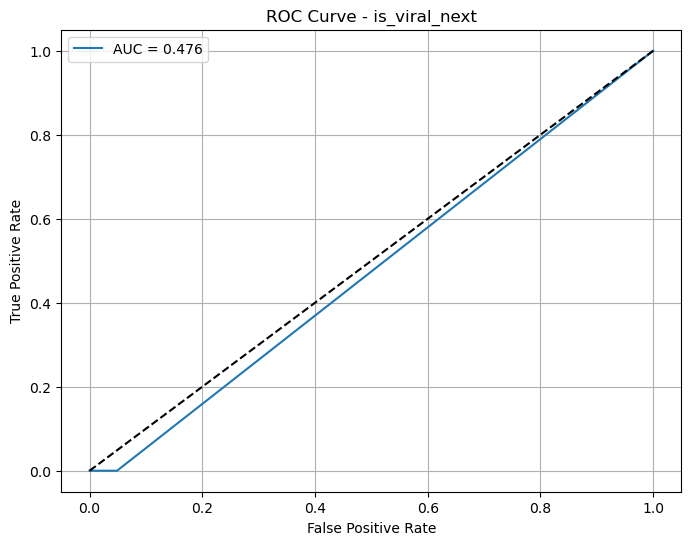



Starting Trend Forecasting for Next 7 Days...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits

Best parameters found for is_viral_next: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}

--- Evaluation for is_viral_next (Prediction Threshold: 0.4) ---
ROC-AUC Score: 0.7290
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1429
           1       0.20      0.19      0.19        16

    accuracy                           0.98      1445
   macro avg       0.60      0.59      0.59      1445
weighted avg       0.98      0.98      0.98      1445


Top 10 Feature Importances:

Best parameters found for is_viral_next: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}

--- Evaluation for is_viral_next (Prediction Threshold: 

,feature,importance
1,num__hashtag_count,0.124107
6,cat__author_barstoolsports,0.065205
35,cat__day_of_week_2,0.056266
9,cat__author_espn,0.050521
0,num__shares,0.047848
36,cat__day_of_week_3,0.045404
2,num__sentiment_polarity,0.042000
34,cat__day_of_week_0,0.033147
19,cat__author_melomontoya,0.026171
47,txt__said,0.024884


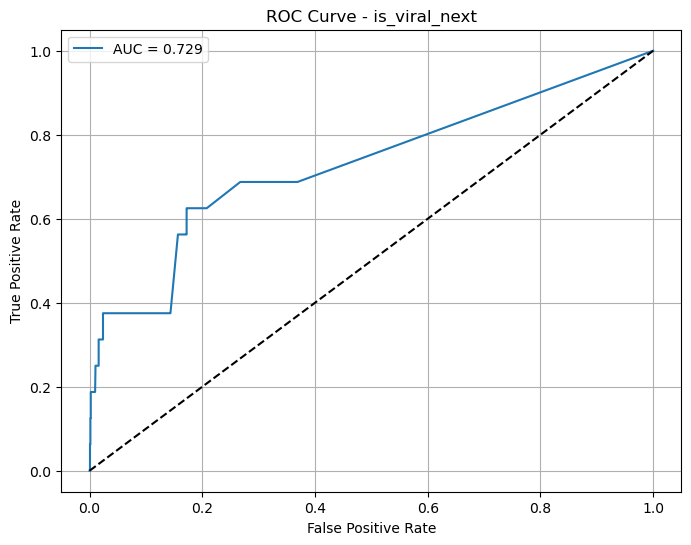

In [35]:
# --- 7. Filter Valid Labeled Rows ---
# Ensure target column 'is_viral_next' is not NaN before passing to the function
df_24h_valid = df_24h[df_24h['is_viral_next'].notna()].copy()
df_7d_valid = df_7d[df_7d['is_viral_next'].notna()].copy()


# --- 8. Run Forecasting for 24h and 7d ---
print("Starting Trend Forecasting for Next 24 Hours...")
top_viral_24h = run_trend_forecasting(df_24h_valid, 'is_viral_next', preprocessor, selector)

print("\n\nStarting Trend Forecasting for Next 7 Days...")
top_viral_7d = run_trend_forecasting(df_7d_valid, 'is_viral_next', preprocessor, selector)

In [36]:
# --- 9. Display Results ---
print("\n--- Top Viral Predictions (Next 24 Hours) ---")
if not top_viral_24h.empty:
    try:
        display(top_viral_24h)
    except NameError:
        print(top_viral_24h)
else:
    print("No viral predictions for the next 24 hours based on the model.")

print("\n--- Top Viral Predictions (Next 7 Days) ---")
if not top_viral_7d.empty:
    try:
        display(top_viral_7d)
    except NameError:
        print(top_viral_7d)
else:
    print("No viral predictions for the next 7 days based on the model.")

print("\nScript execution finished.")


--- Top Viral Predictions (Next 24 Hours) ---


,video_id,create_time,clean_description,author,hashtag_list,hashtag_count,predicted_proba,is_viral
6324,7507463779257552150,2025-05-23 02:34:02,fyp olliespark,olliespark,"['fyp', 'olliespark']",2,0.913333,1
512,7501419708915174687,2025-05-06 19:40:12,no description,reaganssmithh,[],0,0.880000,1
3403,7506362355480071455,2025-05-20 03:19:57,tiktok foryou,dgvizao48242,"['tiktok', 'foryou']",2,0.833333,0
1997,7505641689730551071,2025-05-18 04:43:28,jk,evilfemaledawg,['jk'],1,0.793333,1
6919,7507756543157226798,2025-05-23 21:30:32,this is a good prank barstool gametime viaken,barstoolsports,[],0,0.659855,1
6620,7507651348511329558,2025-05-23 14:41:40,trademark modric realmadrid,realmadrid,"['modric', 'realmadrid']",2,0.526667,1



--- Top Viral Predictions (Next 7 Days) ---


,video_id,create_time,clean_description,author,hashtag_list,hashtag_count,predicted_proba,is_viral
6765,7507703038929341718,2025-05-23 18:02:14,the anime of the year is anime sololeveling fr...,itskingchris,"['anime', 'sololeveling', 'frieren', 'dandadan']",4,0.826667,1
7201,7508055867493862678,2025-05-24 16:51:24,years titles memories modric realmadrid,realmadrid,"['modric', 'realmadrid']",2,0.788095,1
6232,7507437855417863454,2025-05-23 00:53:26,no description,adamnwhodeywant,[],0,0.785000,0
5602,7507289157589503278,2025-05-22 15:16:22,no ipad kid detected barstool gametime viaire...,barstoolsports,[],0,0.774552,0
5234,7507087862320467243,2025-05-22 02:15:41,doggo was nosey i cant even viabaddie j,barstoolsports,[],0,0.739933,0
6315,7507332478743350533,2025-05-23 02:30:00,en larosa mi papá no es un ratero victor el ...,larosadeguadalupe.of,"['larosa', 'originales', 'larosadeguadalupe', ...",5,0.667259,1
6692,7507680775739886864,2025-05-23 16:36:33,sister hero iispoilers ii sorry for the bad q...,raykage.edits,"['liloandstitch', 'stitch', 'lilo', 'disney', ...",7,0.611976,1
4299,7506740397792628014,2025-05-21 03:46:52,if youre not a fan of dark humor we cant be fr...,riiossss1,"['darkhumor', 'copingmechanism', 'fyp', 'xyzbca']",4,0.585556,0
1318,7505198752899075359,2025-05-17 00:04:32,from the timbs to the sweatsuit whole fit is t...,espn,"['timbs', 'sweatsuit', 'fit', 'nbaonespn', 'nb...",6,0.563278,0
5681,7507309760694275358,2025-05-22 16:36:15,bro zooieshawt,zooieshawt,['zooieshawt'],1,0.501881,0



Script execution finished.
